In [3]:
import sys

import matplotlib.pyplot as plt
import multiprocessing as mp
import anndata as ad
import pandas as pd
import scanpy as sc
import argparse
import scipy.stats as stats

import numpy as np
import pickle
import sys
import os
import seaborn as sns
import time
from sklearn.neighbors import KNeighborsClassifier

# Load imports from git directory
import synapse_seq_functions as ssf
import gc

In [4]:
import seaborn as sns

def plot_heatmap(passing_cells_df, title = "", min_col_n=10, min_row_n=10, row_clust = "cell_type_prediction", columns_clust = None, scale_by_col = True, min_value_for_label=5, sort_alpha_numerically=False, show_vert_lines=False, show_horizontal_lines=False, is_wide = False):

# create heatmap of variable "cluster_alias" and "cell_type_prediction"
    if not is_wide:
        passing_cells_df = passing_cells_df[[row_clust, columns_clust]]
        pivot_df = passing_cells_df.pivot_table(index=row_clust, columns=columns_clust, aggfunc=len, fill_value=0)
    else:
        pivot_df = passing_cells_df

    # if column has less than n cells, remove it
    pivot_df = pivot_df.loc[:, pivot_df.sum(axis=0) > min_col_n]
    # if row has less than n cells, remove it
    pivot_df = pivot_df.loc[pivot_df.sum(axis=1) > min_row_n, :]

    pivot_df.sort_index(inplace=True, axis=1, ascending=True)

    # if scaling by columns 
    if not sort_alpha_numerically:
        if scale_by_col:
            max_index = pivot_df.idxmax(axis=0)
            max_index = max_index.sort_values()
            pivot_df = pivot_df[max_index.index]
        else:
            max_index = pivot_df.idxmax(axis=1)
            max_index = max_index.sort_values()
            pivot_df = pivot_df.loc[max_index.index]
    else:
        #sort pivot_df index in place
        pivot_df.sort_index(inplace=True, axis=0, ascending=False)
    annot_mask = np.where(pivot_df > min_value_for_label, pivot_df.astype(str), "")


    # scale by column
    if scale_by_col:
        pivot_df = pivot_df.div(pivot_df.sum(axis=0), axis=1)
    else:
        pivot_df = pivot_df.div(pivot_df.sum(axis=1), axis=0)

    plt.figure(figsize=(30, 20))
    sns.heatmap(pivot_df, cmap="viridis", xticklabels=True, yticklabels=True, cbar=True)
    # sns.heatmap(pivot_df, cmap="viridis", cbar=False)
    # rotate x axis labels 45 degrees
    plt.title(title)
    x_tick_options = {"fontsize": "large"}
    plt.xticks(ha="center", **x_tick_options)
    y_ticks_options = {"fontsize": "large"}
    plt.yticks(**y_ticks_options)

    # Add vertical lines to show separation between ticks
    if show_vert_lines:
        alternating_colors = ["white",  "orange", "yellow", "pink"]
        n_colors = len(alternating_colors)
        for i in range(len(pivot_df.columns)):
            current_color = alternating_colors[i % n_colors]
            plt.axvline(i, color=current_color, linewidth=0.5)

    if show_horizontal_lines:
        alternating_colors = ["white",  "orange", "yellow", "pink"]
        n_colors = len(alternating_colors)
        for i in range(len(pivot_df.index)):
            current_color = alternating_colors[i % n_colors]
            plt.axhline(i, color=current_color, linewidth=0.5)

    plt.show()
    return pivot_df

def v1_in_v2(v1, v2):
    out = np.empty(v1.shape[0],dtype=np.bool_)
    present_set=set(v2)
    for i in range(v1.shape[0]):
        if v1[i] in present_set:
            out[i]=True
        else:
            out[i]=False
    return out

In [5]:
obj = ad.read_h5ad("small_macosko_ref.h5ad")

os.makedirs("pknn_example_dir", exist_ok=True)


# Chunk Reference

In [6]:
n_samples_per_obj = 200
chunked_out_base = os.path.abspath("pknn_example_dir/chunked_objs")
cell_type_col="ClusterNm"


In [6]:

os.makedirs(chunked_out_base, exist_ok=True)


unique_cell_types = obj.obs[cell_type_col].unique()
gene_names = np.array(obj.var_names).flatten()


result_lis = []
cell_type_lis = []

for inx, cell_type in enumerate(unique_cell_types):
    if inx % 10 == 0:
        print(inx)

    is_ct = obj.obs[cell_type_col] == cell_type
    indices = np.array(np.where(is_ct)).flatten()
    n_to_sample = np.min([len(indices), n_samples_per_obj])
    sampled_indices = np.random.choice(a=indices, size=n_to_sample, replace=False)

    sampling_bool = np.zeros(obj.shape[0]).astype(bool)    
    sampling_bool[sampled_indices] = True

    sub_obj = obj[sampling_bool]

    ct_out_path = os.path.join(chunked_out_base, f"{cell_type}.h5ad")
    sub_obj.write_h5ad(ct_out_path)

0
10


# Select Markers

In [7]:
# def compute_and_save_pct_diff_markers(base_chunked_dir, cell_type_1, cell_type_2, n_genes, out_dir_base):
#     # load objs
#     cell_type_1_path = os.path.join(base_chunked_dir, f"{cell_type_1}.h5ad")
#     cell_type_2_path = os.path.join(base_chunked_dir, f"{cell_type_2}.h5ad")

#     assert os.path.exists(cell_type_1_path), f"{cell_type_1_path} DNE"
#     assert os.path.exists(cell_type_2_path), f"{cell_type_2_path} DNE"

#     cell_type_1_adata = ad.read_h5ad(cell_type_1_path)
#     cell_type_2_adata = ad.read_h5ad(cell_type_2_path)

#     assert np.all(cell_type_1_adata.var_names == cell_type_2_adata.var_names)
#     gene_names = cell_type_1_adata.var_names
#     cell_type_1_nonzero_series = pd.Series(np.array(np.mean(cell_type_1_adata.X > 0, axis=0)).flatten(), index=gene_names)
#     cell_type_2_nonzero_series = pd.Series(np.array(np.mean(cell_type_2_adata.X > 0, axis=0)).flatten(), index=gene_names)
    
#     group_1_pos_diff = cell_type_1_nonzero_series - cell_type_2_nonzero_series
#     group_1_pos_sorted = group_1_pos_diff.sort_values(ascending=False)
#     group_1_markers = group_1_pos_sorted[:n_genes]
    
#     group_2_pos_diff = cell_type_2_nonzero_series - cell_type_1_nonzero_series
#     group_2_pos_sorted = group_2_pos_diff.sort_values(ascending=False)
#     group_2_markers = group_2_pos_sorted[:n_genes]
    
#     res = {cell_type_1: group_1_markers, cell_type_2: group_2_markers}

#     kpm.save_pairwise_model(cell_type_1, cell_type_2, out_dir_base, res, "markers")
    



In [7]:
n_markers_dir = 25
chunked_out_base

markers_out_path = "pknn_example_dir/diff_markers_chunked"
markers_out_path_full = os.path.abspath(markers_out_path)

In [8]:

# make sure the directory exists
os.makedirs(markers_out_path_full, exist_ok=True)

chunked_objs_present = os.listdir(chunked_out_base)
cell_types_present = [fname.split(".h5ad")[0] for fname in chunked_objs_present]

de_args = []
for inx_1, ct_name_1 in enumerate(cell_types_present):
    for inx_2, ct_name_2 in enumerate(cell_types_present):
        if inx_2 >= inx_1:
            continue

        arg = (chunked_out_base, ct_name_1, ct_name_2, n_markers_dir, markers_out_path_full)
        de_args.append(arg)

# compute_and_save_pct_diff_markers(*de_args[100])
n_cores = 2
pool = mp.Pool(n_cores)
pool.starmap(ssf.compute_and_save_pct_diff_markers, de_args)
pool.close()
pool.join()


Pairwise classifiers can now be fit, combining the computed markers and chunked objects

In [8]:
# def get_markers_chunked(cell_type_1, cell_type_2, markers_base, suffix=None):

#     obj = kpm.read_in_sorted_subfolder_obj(cell_type_1, cell_type_2, markers_base, suffix=suffix)
#     markers_1 = obj[cell_type_1]
#     markers_2 = obj[cell_type_2]
    
#     combined_markers_index = markers_1.index.append(markers_2.index)
#     # Convert to NumPy array
#     combined_markers = np.array(combined_markers_index)
#     return combined_markers


# def create_classifier_set(inx, current_cell_type, compare_cell_types, chunked_reference_base, markers_base, base_classifier_path, n_features_directional=25, cell_per_type=200, equal_size_n=False):
#     f_name="classifier"
#     if inx % 10 == 0:
#         print(f"Working on inx: {inx}")
#     # base_classifier_path = "/home/jsilverm/MouseBrainAtlasData/IntegrationFunctions/07_transfer_benchmarking/objects/whole_brain_classifiers"
#     if not os.path.exists(base_classifier_path):
#         os.makedirs(base_classifier_path)
#     for cell_type in compare_cell_types:
#         model_exists = check_if_model_exists(current_cell_type, cell_type, base_classifier_path, f_name)
#         if model_exists:
#             continue

#         markers = get_markers_chunked(current_cell_type, cell_type, markers_base=markers_base, suffix="markers")
                                      
#         classifier = create_classifier_pair(cell_type_1 = current_cell_type, cell_type_2=cell_type, 
#                                             chunked_reference_base=chunked_reference_base, 
#                                             markers=markers,  cell_per_type=cell_per_type, 
#                                             equal_size_n=equal_size_n)
        
#         res_obj = {"classifier": classifier, "cell_type1": cell_type, "cell_type2": current_cell_type,  "markers": markers}

#         # save in indexable system
#         save_pairwise_model(current_cell_type, cell_type, base_classifier_path, res_obj, f_name, order_alphabetically=True)



# def create_classifier_pair(cell_type_1, cell_type_2, chunked_reference_base, markers, cell_per_type = 200, equal_size_n = False):
    
#     cell_type_1_path = os.path.join(chunked_reference_base, f"{cell_type_1}.h5ad")
#     cell_type_2_path = os.path.join(chunked_reference_base, f"{cell_type_2}.h5ad")

#     assert os.path.exists(cell_type_1_path), f"{cell_type_1_path} DNE"
#     assert os.path.exists(cell_type_2_path), f"{cell_type_2_path} DNE"

#     cell_type_1_adata = ad.read_h5ad(cell_type_1_path)
#     cell_type_2_adata = ad.read_h5ad(cell_type_2_path)
    
#     # subset each object to the min of cell_per_type cells or the number of cells in the object
#     n_cells_cell_type_1 = cell_type_1_adata.shape[0]
#     n_cells_cell_type_2 = cell_type_2_adata.shape[0]


#     if equal_size_n:
#       min_size = np.min(n_cells_cell_type_1, n_cells_cell_type_2)
#       if min_size < cell_per_type:
#         n_to_sample_to = min_size
#       else:
#         n_to_sample_to = cell_per_type
#       cell_type_1_adata =  cell_type_1_adata[np.random.choice(n_cells_cell_type_1, n_to_sample_to, replace=False), :].copy()
#       cell_type_2_adata =  cell_type_2_adata[np.random.choice(n_cells_cell_type_2, n_to_sample_to, replace=False), :].copy()
#     else:
#       if n_cells_cell_type_1 > cell_per_type:
#           cell_type_1_adata = cell_type_1_adata[np.random.choice(n_cells_cell_type_1, cell_per_type, replace=False), :].copy()
#       if n_cells_cell_type_2 > cell_per_type:
#           cell_type_2_adata = cell_type_2_adata[np.random.choice(n_cells_cell_type_2, cell_per_type, replace=False), :].copy()
  
#     #normalize log both objects
#     sc.pp.normalize_total(cell_type_1_adata, target_sum=1e4)
#     sc.pp.log1p(cell_type_1_adata)

#     sc.pp.normalize_total(cell_type_2_adata, target_sum=1e4)
#     sc.pp.log1p(cell_type_2_adata)

#     cell_type_1_mat_markers_only = cell_type_1_adata[:, markers].X.toarray()
#     cell_type_2_mat_markers_only = cell_type_2_adata[:, markers].X.toarray()

#     knn_classifer = KNeighborsClassifier(n_neighbors=12, metric="cosine", weights="distance")
#     reference_labels = [cell_type_1] * cell_type_1_mat_markers_only.shape[0] + [cell_type_2] * cell_type_2_mat_markers_only.shape[0]
#     training_data = np.vstack([cell_type_1_mat_markers_only, cell_type_2_mat_markers_only])
#     knn_classifer.fit(training_data, reference_labels)
#     return knn_classifer


# def check_if_model_exists(group1, group2, base_path, suffix, sort_alphabetically=True):
#     if sort_alphabetically:
#         if group1 > group2:
#             group1, group2 = group2, group1
#     outer_folder = os.path.join(base_path, group1)
#     if not os.path.exists(outer_folder):
#         return False

#     inner_folder = os.path.join(outer_folder, group2)
#     if not os.path.exists(inner_folder):
#         return False

#     model_path = os.path.join(inner_folder, f"{suffix}.pkl")
#     if not os.path.exists(model_path):
#         return False
#     return True


# def save_pairwise_model(group1, group2, base_path, obj, suffix, order_alphabetically=True):
#     # sort names alphabetically
#     # make the outer folder the first name and inner the second
#     if order_alphabetically:
#         if group1 > group2:
#             group1, group2 = group2, group1

#     outer_folder = os.path.join(base_path, group1)
#     if not os.path.exists(outer_folder):
#         os.makedirs(outer_folder)

#     inner_folder = os.path.join(outer_folder, group2)
#     if not os.path.exists(inner_folder):
#         os.makedirs(inner_folder)
    
#     model_path = os.path.join(inner_folder, f"{suffix}.pkl")
#     # print(f"saving model to {model_path}")
#     pickle.dump(obj, open(model_path, "wb"))

In [8]:

chunked_out_base
markers_out_path_full

classifier_out_path = os.path.abspath("pknn_example_dir/classifiers")

os.makedirs(classifier_out_path, exist_ok=True)
n_features_directional=25
cell_per_type=200
equal_size_n=False
from_macosko=False

In [10]:
chunked_objs_present = os.listdir(chunked_out_base)
cell_types = [obj_fname.split(".h5ad")[0] for obj_fname in chunked_objs_present]

n_cores = 2
args_create_knn = [(inx, cell_type, cell_types[inx+1:], chunked_out_base,
                    markers_out_path_full, classifier_out_path, n_features_directional, cell_per_type, equal_size_n) for inx, cell_type in enumerate(cell_types)]


# create_classifier_set(*args_create_knn[0])
pool = mp.Pool(n_cores)
pool.starmap(ssf.create_classifier_set, args_create_knn)
pool.close()
pool.join()



Working on inx: 0
Working on inx: 10


Create subsampled reference to initially place cells

If the reference type has excess cells for a type, they are held out as a test set. 

In [9]:
# Want to hold some cells from each cell type for testing
np.random.seed(42)

max_ref = 50
max_query=30
min_size_to_use=20

In [10]:

cell_type_names, sizes = np.unique(obj.obs[cell_type_col], return_counts=True)
n_cell_types = len(cell_type_names)

ref_indices = []
query_indices = []

types_passing = []
types_too_small = []
for inx, (cell_type, size) in enumerate(zip(cell_type_names, sizes)):
    # track progress
    if inx % 10 == 0:
        print(inx)
         
    if size < min_size_to_use:
        types_too_small.append(cell_type)
        continue
    types_passing.append(cell_type)


    size_for_ref = min([max_ref, size])
    is_cell_type_bool = obj.obs[cell_type_col] == cell_type
    indices_for_cell_type = np.where(is_cell_type_bool)[0]

    # take a random sample of the indices
    indices_for_ref = np.random.choice(indices_for_cell_type, size_for_ref, replace=False)
    ref_indices.extend(list(indices_for_ref))
    is_cell_type_bool.iloc[indices_for_ref] = False

    excess_cells = size - size_for_ref

    if excess_cells > 10:
        size_for_query = min(excess_cells, max_query)
        
        indices_possible_query_sample = np.where(is_cell_type_bool)[0]
        indices_for_query = np.random.choice(indices_possible_query_sample, size_for_query, replace=False)
    
        query_indices.extend(list(indices_for_query))


0
10


In [18]:
query_obj = obj[query_indices]
ref_obj = obj[ref_indices]

assert len(set(query_obj.obs_names).intersection(ref_obj.obs_names)) == 0

Test predictions on query cells

In [19]:
chunked_reference_base="pknn_example_dir/chunked_objs"

classifier_out_path = "pknn_example_dir/classifiers"

n_neighbors_h0=10
n_next_cell_types_compare=10
models_are_folder_chunked=True

In [13]:
#assert that genes match
assert all(ref_obj.var.index == query_obj.var.index), "Genes do not match"
query_obj.obs["source"] = "query"
ref_obj.obs["source"] = "reference"

### Combine Objects and Run Clustering Workflow to create intial embedding###
print("Combining objects and running clustering workflow")


combined_obj = ad.concat([query_obj, ref_obj], join="outer")
combined_obj = ssf.run_clustering_workflow(combined_obj)

print("Running pknn")


/tmp/ipykernel_8149/1383002254.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  query_obj.obs["source"] = "query"
/tmp/ipykernel_8149/1383002254.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ref_obj.obs["source"] = "reference"


Combining objects and running clustering workflow
Normalizing and log transforming
Finding variable genes
Filtering to highly variable genes
AnnData object with n_obs × n_vars = 1409 × 4000
    obs: 'ClusterKey', 'ClusterNm', 'derived_cell_libs', 'class', 'source'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
Scaling data
Running PCA
Running pknn


In [15]:
pairwise_pred_results = ssf.preform_pairwise_knn_prediction(model_path=classifier_out_path, n_neighbors_h0 = n_neighbors_h0, query_obj = query_obj, combined_obj = combined_obj, n_next_cell_types_compare=n_next_cell_types_compare, n_cores = 2, embed_key="X_pca", models_are_folder_chunked=models_are_folder_chunked, ref_ct_label=cell_type_col)


Running n_groups comparisons for cellular predictions. n_next_cell_types_compare provided.
Mon Nov  4 21:56:07 2024
Building knn graph for reference data.
Running knn classifier for query data. k = 500
Parsing knn results. Establish future comparisons
0
Mon Nov  4 21:56:07 2024
Converting query to dense. Will spike memory.
Constructing args
Beginning parallel processing
0
Mon Nov  4 21:56:11 2024
Parsing first round results
Mon Nov  4 21:56:11 2024
Running secondary comparisons
Constructing args for 26 cell type comparisons
0
Mon Nov  4 21:56:11 2024
Seconary results done
Mon Nov  4 21:56:11 2024
Parsing combined results
0
Mon Nov  4 21:56:11 2024


In [20]:
result_df = pairwise_pred_results["cellular_prediction_df"]
query_meta = query_obj.obs

merged_meta = pd.merge(result_df, query_meta, right_index=True, left_index=True)
match_rate = np.mean(merged_meta["cell_type_prediction"] == merged_meta[cell_type_col])

result_df_passing = result_df.loc[result_df["pass_rate"] == 1]
merged_meta_passing = pd.merge(result_df_passing, query_meta, right_index=True, left_index=True, how="inner")

match_rate_passing= np.mean(merged_meta_passing["cell_type_prediction"] == merged_meta_passing[cell_type_col])


/tmp/ipykernel_8149/242546390.py:8: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_df = passing_cells_df.pivot_table(index=row_clust, columns=columns_clust, aggfunc=len, fill_value=0)


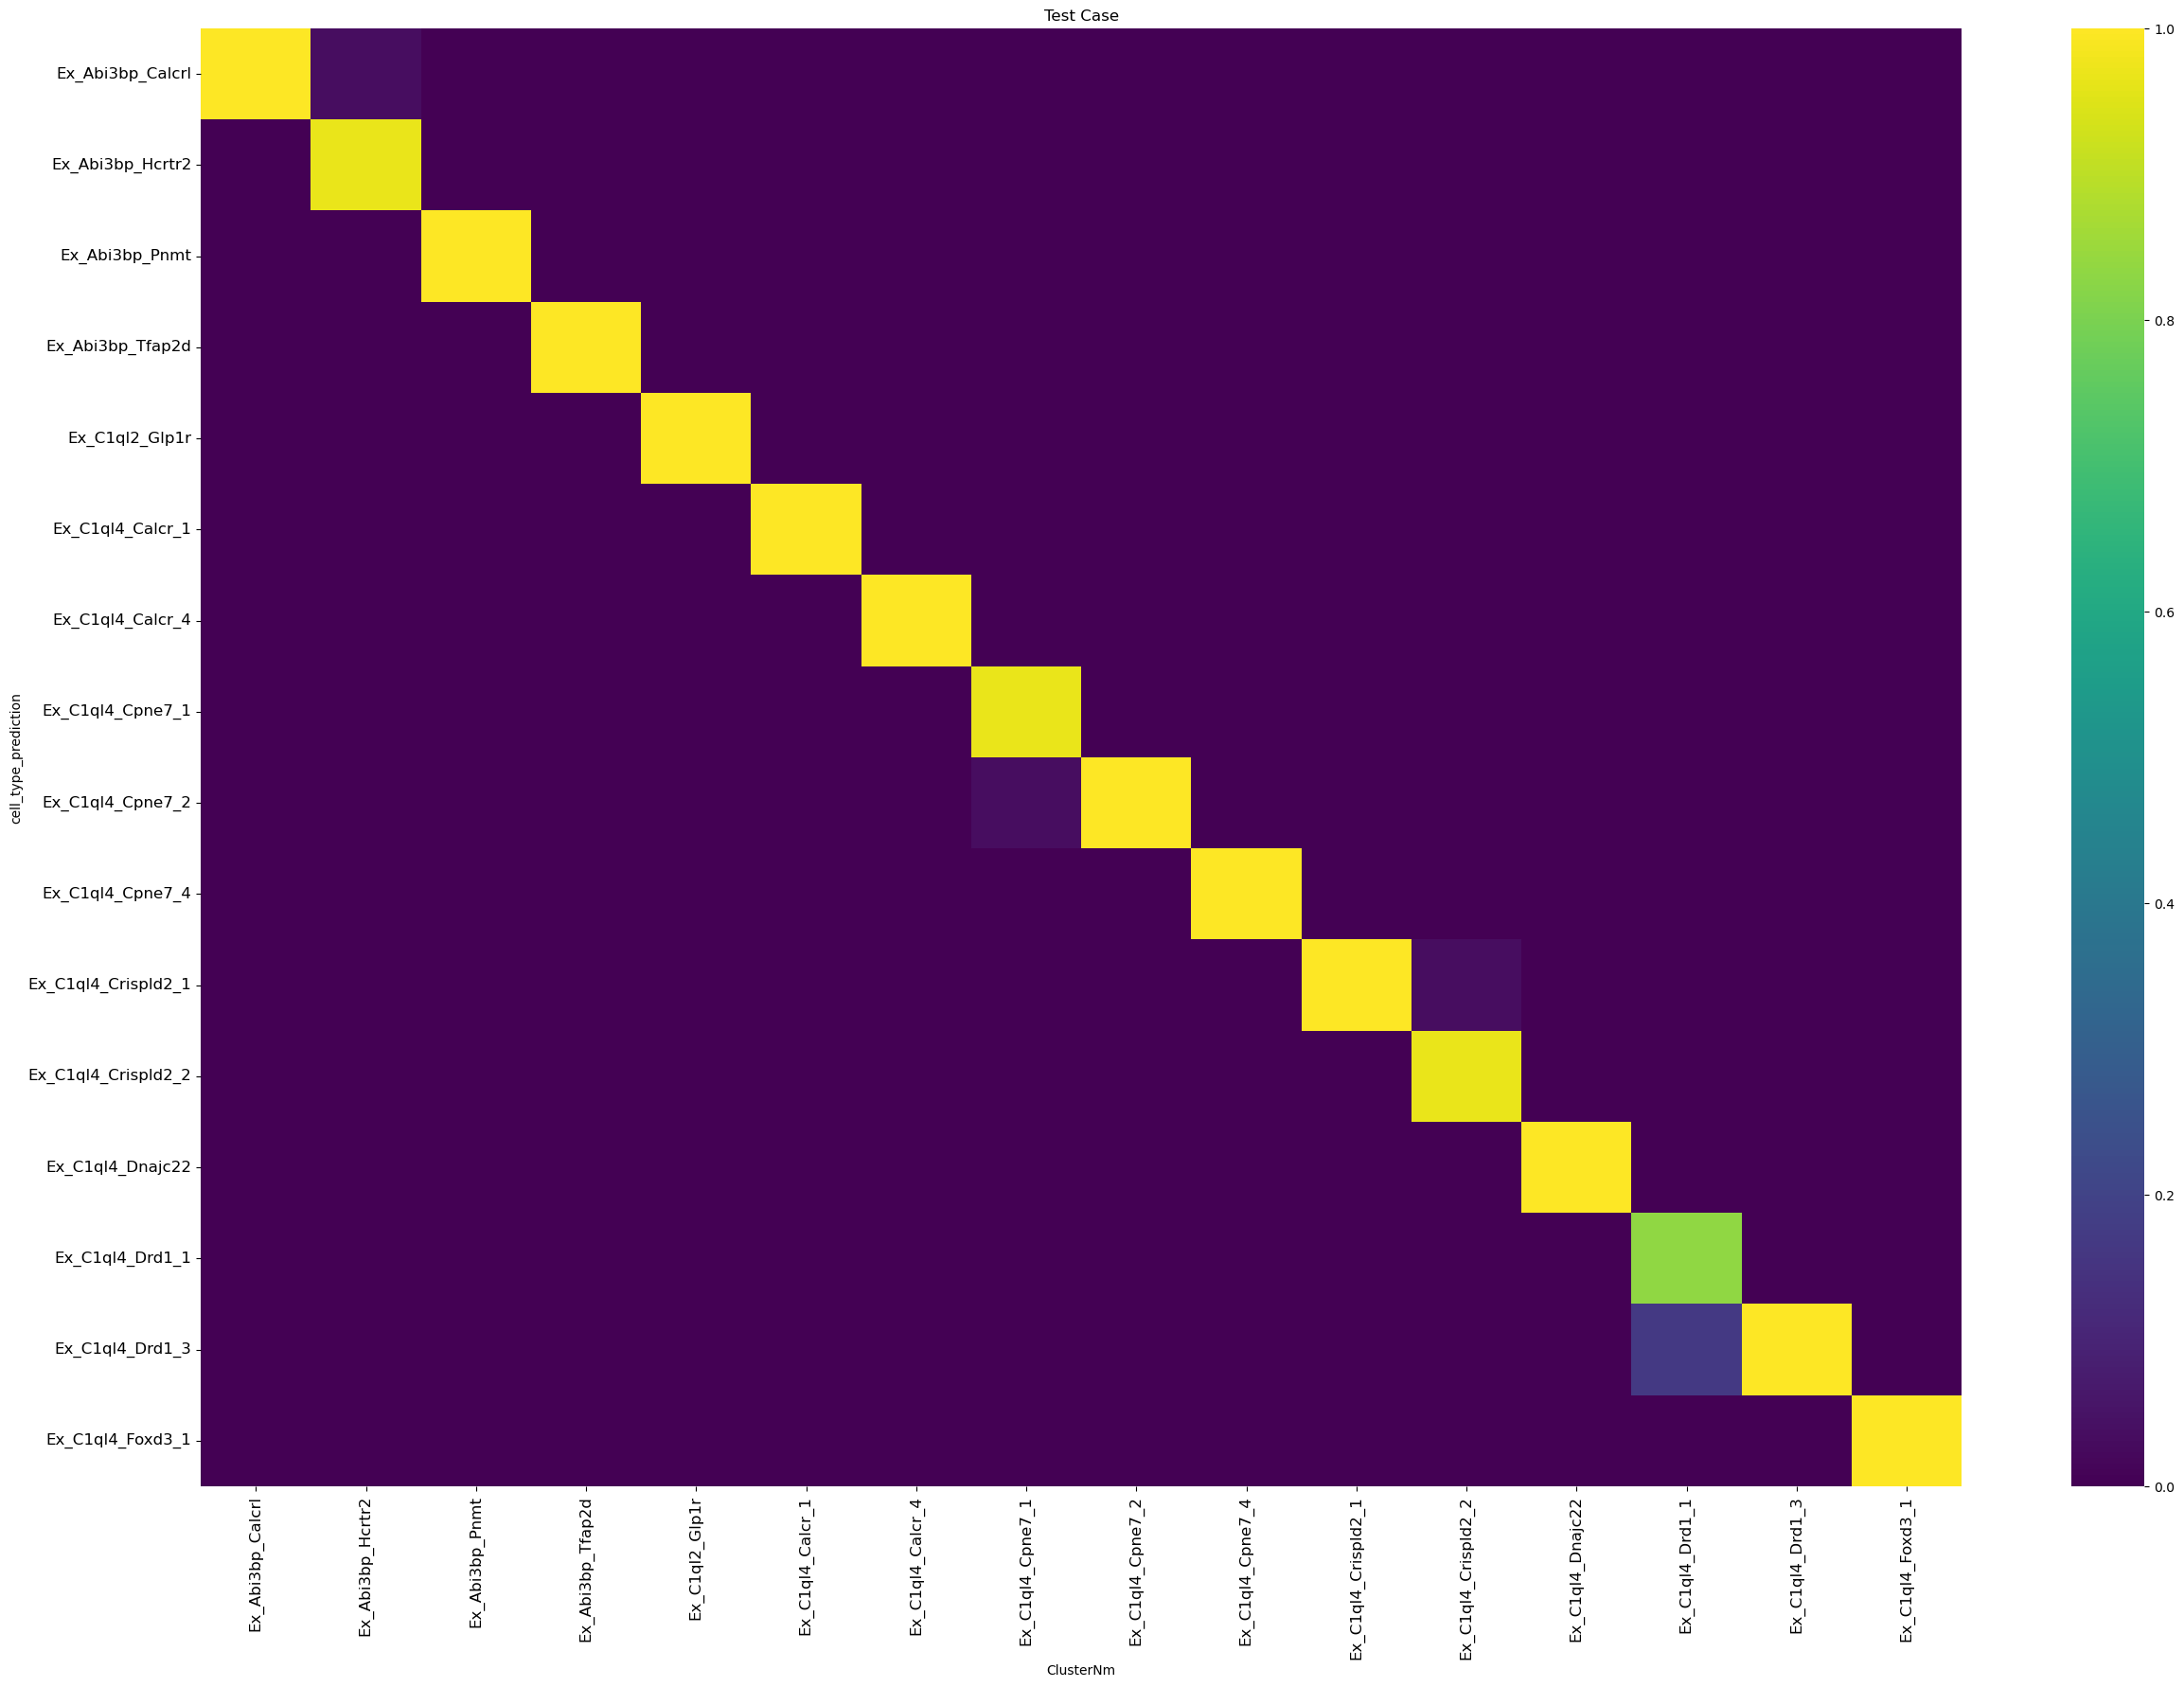

In [21]:
_ = plot_heatmap(merged_meta, title="Test Case", columns_clust=cell_type_col,min_value_for_label=0, min_col_n=0, min_row_n=0)